# MLP2
## Jonathan Doan & Jesse McQuillan

In [247]:
# Common imports
import numpy as np
import pandas as pd
import re

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# to make this notebook's output stable across runs
np.random.seed(42)

### Tweets.csv
Contains 410,186 tweets 

In [249]:

wordleTweets = pd.read_csv("../rawdata/tweets.csv")
wordleTweets.head(20)
wordleTweets.tail()

,wordle_id,tweet_id,tweet_date,tweet_username,tweet_text
410182,291,1511736826435878913,2022-04-06 16:05:20+00:00,SpottedLights,Wordle 291 4/6\n\n🟨⬛⬛⬛⬛\n⬛⬛🟨⬛⬛\n🟩⬛🟨🟨⬛\n🟩🟩🟩🟩🟩
410183,291,1511736827195011072,2022-04-06 16:05:20+00:00,AlisonB916,Wordle 291 4/6\n\n⬜🟩⬜⬜⬜\n⬜⬜🟨⬜⬜\n🟩🟩⬜⬜🟩\n🟩🟩🟩🟩🟩
410184,291,1511736850741878784,2022-04-06 16:05:26+00:00,Nico19596830,Wordle 291 4/6\n\n🟩⬛⬛🟨🟨\n🟩🟨🟩⬛⬛\n⬛🟩⬛⬛⬛\n🟩🟩🟩🟩🟩
410185,291,1511736856433631233,2022-04-06 16:05:27+00:00,RumzHere,Wordle 291 3/6\n\n🟩⬜🟨🟩⬜\n🟩🟨🟩⬜🟨\n🟩🟩🟩🟩🟩
410186,291,1511736863987490826,2022-04-06 16:05:29+00:00,weboggle,Wordle 291 4/6\n\n⬜⬜⬜🟨⬜\n🟩🟩⬜⬜⬜\n🟩🟩⬜⬜🟩\n🟩🟩🟩🟩🟩\n🌃


In [197]:
#sort them by wordle id to make prevent out of sequence errors
wordleTweets.sort_values(by=['wordle_id'], inplace=True)

games = []
daily = []
cur_id = 0

#process each tweet to make text machine readable
for index, tweet in wordleTweets.iterrows():
    
    #Set first index
    if index == 0:
        cur_id = tweet.wordle_id
        
    #find all guess emoju strings
    raw_guesses = re.findall("([🟩🟨⬛⬜]+)", tweet.tweet_text)
    single_game = []
    
    #replace emojs with letter
    for guess in raw_guesses:
        guess = guess.replace("🟩", 'G')
        guess = guess.replace("🟨", 'Y')
        guess = guess.replace("⬛", 'B')
        guess = guess.replace("⬜", 'B')
        single_game.append(guess)
    #print(single_game)
    
    #add to the days games
    daily.append(single_game[:])
    
    #add the day to the list and start a new daily
    if tweet.wordle_id != cur_id:
        #print(len(daily))
        games.append(daily[:])
        daily.clear()
        cur_id = tweet.wordle_id

print("Complete!")

Complete!


In [198]:
# Used for checking the data
#for game in games:
#    print(len(game))

In [191]:
word_freqs = pd.read_csv("../rawdata/unigram_freq.csv")

print(word_freqs.describe(),'\n')

print(word_freqs.isnull().any(), '\n')

word_freqs.dropna(inplace=True)

print(word_freqs.isnull().any(), '\n')

word_freqs.head()

              count
count  3.333330e+05
mean   1.764374e+06
std    6.629987e+07
min    1.271100e+04
25%    2.122400e+04
50%    4.151900e+04
75%    1.365760e+05
max    2.313585e+10 

word      True
count    False
dtype: bool 

word     False
count    False
dtype: bool 



,word,count
0,the,23135851162
1,of,13151942776
2,and,12997637966
3,to,12136980858
4,a,9081174698


In [192]:
#Read answers
answers_file = open("../rawdata/answers.txt")
raw_answers = answers_file.read()
answers = raw_answers.splitlines()
#print(answers[:10])

#Read other words
other_words_file = open("../rawdata/other_words.txt")
raw_other_words = other_words_file.read()
other_words = raw_other_words.splitlines()
#print(other_words[:10])

#combine them
words = sorted(answers + other_words)

In [193]:
#Create a lit of every possible tile combination
import itertools

unique_tiles = ['G', 'Y', 'B']
impossible_tiles = ['GGGGG', 'GGGGY', 'GGGYG', 'GGYGG', 'GYGGG', 'YGGGG', ]
tile_combos = []

for raw_answer in itertools.product(unique_tiles, repeat=5):
    clean_answer = ''.join(raw_answer)
    if clean_answer not in impossible_tiles:
        tile_combos.append(''.join(raw_answer))

#print (tile_combos)

In [244]:
#Takes in a word and returns a distribution of probably answers based on how many words correspond to a particular tile response
word_size = 5
new_line = '\n'
GREEN = 'G'
YELLOW = 'Y'
BLACK = 'B'

#Takes in a word and a set of tiles, and returns a list of all valid five letter words given the conditions
def get_possible_answers(word, tiles):
    re_exp = ""
    remaining_words = words
    #print(len(remaining_words))
    #print(tiles)
    for i in range(word_size):
        if tiles[i] == GREEN:
            for j in range(word_size):
                if i == j:
                    re_exp += word[i]
                if i != j:
                    re_exp += '.'
        if tiles[i] == YELLOW:
            more_re = re.compile(r'(?=[a-z]*[' + word[i] + '])[a-z]{5}')
            remaining_words = list(filter(more_re.search, remaining_words))
            for j in range(word_size):
                if j == 0:
                    re_exp += '^'
                if i == j:
                    re_exp += '[^' + word[i] + ']'
                if i != j:
                    re_exp += '.'
        if tiles[i] == BLACK:
            for j in range(word_size):
                if j == 0:
                    re_exp += '^'
                if i == j:
                    re_exp += '[^' + word[i] + ']'
                if i != j:
                    re_exp += '.'
        
        #print(re_exp)
        remaining_words = list(filter(re.compile(re_exp).search, remaining_words)) 
        #print(remaining_words)
        re_exp = ''
    #print(remaining_words_list)
    #print('words found')
    return remaining_words
    

# takes in a word and returns a dictionary tile combinations as keys and lists of possible words as values
def get_guess_word_distro(word):
    answer_dict = {}
    for combo in tile_combinations:
        remaining_possibilities = get_possible_answers(word, combo)
        answer_dict[combo] = remaining_possibilities
    #print('distro found')
    return answer_dict

#converts a pattern, word dictionary to a sorted pandas dataframe with counts of how many words correspond with each pattern
def word_to_count_distro(guess_words_dict):
    cols = ['pattern','count']
    df_guess_dist = pd.DataFrame(data=None, columns=cols)
    for tiles, guesses in guess_words_dict.items():
        #print(tiles, len(guesses))
        data = [tiles, len(guesses)]
        df_guess_dist.loc[len(df_guess_dist.index)+1] = data
    df_guess_dist.set_index('pattern')
    df_guess_dist['count'] = pd.to_numeric(df_guess_dist["count"])
    df_guess_dist.sort_values(by=['count'], inplace=True)
    return df_guess_dist


<AxesSubplot:>

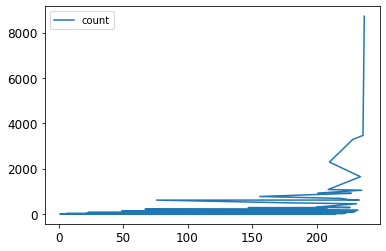

In [245]:
check_my_distribution = 'crane'

guess_words_dict = get_guess_word_distro(check_my_distribution)

df_distro = word_to_count_distro(guess_words_dict)

df_distro.plot()



In [232]:
df_guess_dist.describe()
#df_guess_dist.head()

,count
count,237.000000
mean,130.662447
std,691.815258
min,0.000000
25%,0.000000
50%,4.000000
75%,26.000000
max,9072.000000


<AxesSubplot:>

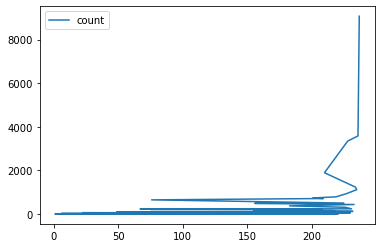

In [235]:
df_guess_dist.plot()


In [ ]:
#Mostly debugging code but I didn't think it should get thrown away yet

#word = 'grape'
#i = 2
#more_re = '(?![a-z]*[' + word[i] + '])[a-z]{5})'
#print (more_re)
#contains = 'al'
#contains_re = '(?=[a-z]*[{0}])'.format(contains)
#disallowed = 'h'
#disallowed_re = '(?![a-z]*[{0}])'.format(disallowed)
#match = 'tr'
#word_size = 5
#match_re = '[a-z]{'+ str(word_size - len(match)) + '}'
#final_re = match + contains_re + disallowed_re + match_re
#print(final_re)

#new_line = '\n'
#remaining_words = new_line.join(words)
#print (remaining_words)
#more_re = r'^[^b]....$'
#results = re.findall(more_re, remaining_words)
#print(len(results))
#print(results)
#print(new_line.join(results))

#test = ['blabs', 'black', 'blade', 'blads', 'blady', 'blaer', 'blaes', 'blaff', 'blags', 'blahs', 'blain', 'blame', 'blams', 'bland', 'blank', 'blare', 'blart', 'blase', 'blash', 'blast', 'blate', 'blats', 'blatt', 'blaud', 'blawn', 'blaws', 'blays', 'blaze']
#temp_re = re.compile(r'^....s')

#results = list(filter(temp_re.search, test)) 
#print(len(results))
#print(results)